In [1]:
import numpy as np
import cv2
from pathlib import Path
import matplotlib.pyplot as plt

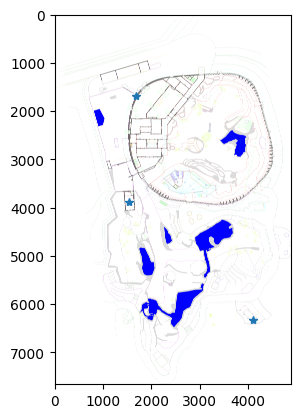

In [2]:
# Map to world constraints
world_points=np.array([(-73.29,55.69),(-77.21,-6.51),(-4.88,-75.34)])
map_points=np.array([(1682,1683),(1543,3886),(4106,6327)])

def imread_rgb(name):
    m = cv2.imread(name)
    return cv2.cvtColor(m,cv2.COLOR_BGR2RGB)
im_map = imread_rgb("../data/kkep_floorplan.png")
plt.imshow(im_map)
plt.plot(map_points[:,0],map_points[:,1],"*")

In [3]:
# Map to world calibration
from optimization_helpers import optimizeModel,IModelEvaluator


class Similarity2DEvaluator(IModelEvaluator[np.ndarray]):
    def __init__(self, points_a: np.ndarray, points_b: np.ndarray):
        super().__init__()
        count, _ = points_a.shape
        assert points_a.shape == (count, 2)
        assert points_a.shape == points_b.shape

        self.points_a = points_a
        self.points_b = points_b

    def model2params(self, model: np.ndarray) -> np.ndarray:
        return np.array([model[0, 0], model[1, 1], model[0, 2], model[1, 2]])

    def params2model(self, params: np.ndarray) -> np.ndarray:
        return np.array([[params[0], 0, params[2]], [0, params[1], params[3]],[0,0,1]])

    def getParamBounds(self) -> None:
        return None

    def evaluateModel(self, model: np.ndarray) -> float:
        scale = model[:2, :2]
        offset = model[:2, [2]]

        points_aa = scale @ self.points_b.T + offset
        cost = np.sum(np.linalg.norm(points_aa-self.points_a.T,axis=1))
        return cost
    
evaluator = Similarity2DEvaluator(map_points,world_points)
m0 = np.array([[1,0,0],[0,1,0]])
display(evaluator.evaluateModel(m0))
T_map_from_world = optimizeModel(evaluator,m0,debug=True)
display("")
print(f"Final error in pixels: {evaluator.evaluateModel(T_map_from_world)}")
print(f"{T_map_from_world=}")
T_world_from_map = np.linalg.inv(T_map_from_world)
print(f"{T_world_from_map=}")


np.float64(12421.96580509311)

         Current function value: 1.300833
         Iterations: 63
         Function evaluations: 666
         Gradient evaluations: 131
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 1.3008329167036423
        x: [ 3.543e+01 -3.544e+01  4.279e+03  3.656e+03]
      nit: 63
      jac: [-1.866e-05  2.447e-05  4.619e-07  1.639e-07]
 hess_inv: [[ 2.219e-05  7.056e-07  1.151e-03  6.700e-05]
            [ 7.056e-07  1.462e-04 -1.200e-04  1.239e-03]
            [ 1.151e-03 -1.200e-04  8.288e-02  1.783e-03]
            [ 6.700e-05  1.239e-03  1.783e-03  4.363e-01]]
     nfev: 666
     njev: 131


/home/dherrera/git/zoo_vision/env/lib/python3.11/site-packages/scipy/optimize/_minimize.py:733: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


''

Final error in pixels: 1.3008329167036423
T_map_from_world=array([[ 3.54341920e+01,  0.00000000e+00,  4.27892158e+03],
       [ 0.00000000e+00, -3.54426533e+01,  3.65627340e+03],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])
T_world_from_map=array([[ 2.82213293e-02,  0.00000000e+00, -1.20756855e+02],
       [-0.00000000e+00, -2.82145920e-02,  1.03160262e+02],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])


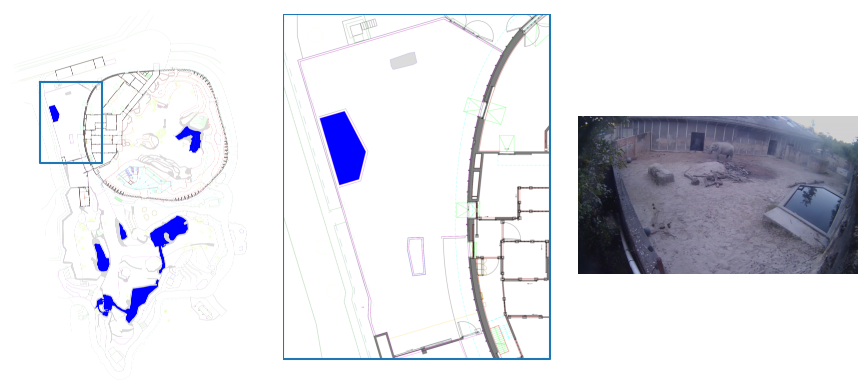

In [4]:
# Get submap for specific camera
from glob import glob
camera_name = "Kamera 01"
submap_xy = np.array([626,1500])
submap_end = np.array([1912,3164])

im_submap = im_map[submap_xy[1]:submap_end[1],submap_xy[0]:submap_end[0],:]
T_submap_from_world = T_map_from_world.copy()
T_submap_from_world[0,2] -= submap_xy[0]
T_submap_from_world[1,2] -= submap_xy[1]
T_world_from_submap = np.linalg.inv(T_submap_from_world)

submap_corners_in_map = np.stack([submap_xy,submap_end])
submap_corners_in_map = np.concatenate([submap_corners_in_map, np.ones((2,1))],axis=1)
submap_corners_in_world = (T_world_from_map @ submap_corners_in_map.T).T
submap_corners_in_submap = (T_submap_from_world @ submap_corners_in_world.T).T
def plot_rectangle_xyxy(ax,points):
    x0,y0 = points[0,0:2]
    x1,y1 = points[1,0:2]
    ax.plot([x0,x0,x1,x1,x0],[y0,y1,y1,y0,y0],"-")

image_filename = glob(f"../data/cameras/{camera_name}/*.jpg")[0]
im_camera = imread_rgb(image_filename)
fig,axs = plt.subplots(1,3,figsize=(9,4))
axs[0].imshow(im_map)
plot_rectangle_xyxy(axs[0],submap_corners_in_map)
axs[1].imshow(im_submap)
plot_rectangle_xyxy(axs[1],submap_corners_in_submap)
axs[2].imshow(im_camera)
for ax in axs:
    ax.set_axis_off()
fig.tight_layout()

In [5]:
cv2.startWindowThread()

0

In [6]:
class MouseHandler:
    def __init__(self,img,window_name):
        self.img = img.copy()
        self.window_name = window_name
        self.positions = []

    def start(self):
        cv2.namedWindow(self.window_name)
        cv2.setMouseCallback(self.window_name,self)
        cv2.imshow(self.window_name,self.img)

    def __call__(self,event,x,y,flags,param):
        if event == cv2.EVENT_LBUTTONDOWN:
            self.positions.append((x,y))
            count = len(self.positions)
            color = [0,0,0]
            color[count%3] = 200
            self.img = cv2.circle(self.img, (x,y),radius=10, color=color, thickness=5)
            cv2.imshow(self.window_name,self.img)

submapClicker=MouseHandler(im_submap, "submap")
cameraClicker = MouseHandler(im_camera, f"camera: {camera_name}")

submapClicker.positions=[(962, 424), (942, 494), (890, 911), (517, 222), (624, 1261), (1057, 190)]
cameraClicker.positions=[(769, 242), (860, 249), (1295, 277), (571, 471), (1709, 384), (497, 234)]
if len(submapClicker.positions)== 0 or len(cameraClicker.positions)==0:
    submapClicker.start()
    cameraClicker.start()

    key = cv2.waitKey(0)
    cv2.destroyAllWindows()

print(submapClicker.positions)
print(cameraClicker.positions)

[(962, 424), (942, 494), (890, 911), (517, 222), (624, 1261), (1057, 190)]
[(769, 242), (860, 249), (1295, 277), (571, 471), (1709, 384), (497, 234)]


In [7]:
def to_h(x):
    count = x.shape[0]
    dcount = x.shape[1]
    if dcount not in [2,3]:
        raise RuntimeError(f"dcount not 2 or 3: {x.shape}")

    # assert x.shape[-1] == 2
    xh = np.empty((x.shape[0],x.shape[1]+1))
    xh[:,:-1] = x
    xh[:,-1] = 1
    return xh.T

def from_h(xh):
    xh = xh.T
    count = xh.shape[0]
    dcount = xh.shape[1]
    if dcount not in [2,3]:
        raise RuntimeError(f"dcount not 2 or 3: {xh.shape}")

    return (xh[:,0:(dcount-1)] / xh[:,[dcount-1]])
camera_points = np.array(cameraClicker.positions)
submap_points = np.array(submapClicker.positions)
world_points = from_h(T_world_from_submap @ to_h(submap_points))
print(world_points)

# p = camera_points[[0]]
# display(p.shape, p)
# ph = to_h(p)
# display(ph.shape, ph)
# pp = from_h(ph)
# display(pp.shape, pp)



H_submap_from_camera,inliers=cv2.findHomography(camera_points, submap_points)
print(f"Inliners {inliers.sum()/len(inliers):.0%}")
display(H_submap_from_camera)
H_camera_from_submap = np.linalg.inv(H_submap_from_camera)

errors = np.linalg.norm(submap_points - from_h(H_submap_from_camera @ to_h(camera_points)), axis=1)
print("Errors (submap units): ", errors)

H_world_from_camera = T_world_from_submap @ H_submap_from_camera
H_camera_from_world = np.linalg.inv(H_world_from_camera)
display(H_world_from_camera)

errors = np.linalg.norm(world_points - from_h(H_world_from_camera @ to_h(camera_points)), axis=1)
print("Errors (world units): ", errors)


[[-75.94138408  48.87538707]
 [-76.50581067  46.90036564]
 [-77.97331979  35.13488078]
 [-88.49987561  54.57473465]
 [-85.48019338  25.2597736 ]
 [-73.2603578   55.47760159]]
Inliners 100%


array([[-5.44209218e-02, -2.14886660e+00,  1.54433213e+03],
       [ 9.18273588e-01, -1.32105125e-01, -2.47865864e+02],
       [ 2.72019087e-05, -1.04922264e-04,  1.00000000e+00]])

Errors (submap units):  [25.22849485 28.29966369 20.51878593  1.7354459   2.55210152 32.92392298]


array([[-4.34008376e-03, -4.98274040e-02, -5.95071973e+01],
       [-2.42537947e-02, -2.65600773e-03,  6.78318083e+01],
       [ 2.72019087e-05, -1.04922264e-04,  1.00000000e+00]])

Errors (world units):  [0.71197688 0.79859049 0.57902142 0.04897637 0.07201409 0.92913468]


(1061, 600)

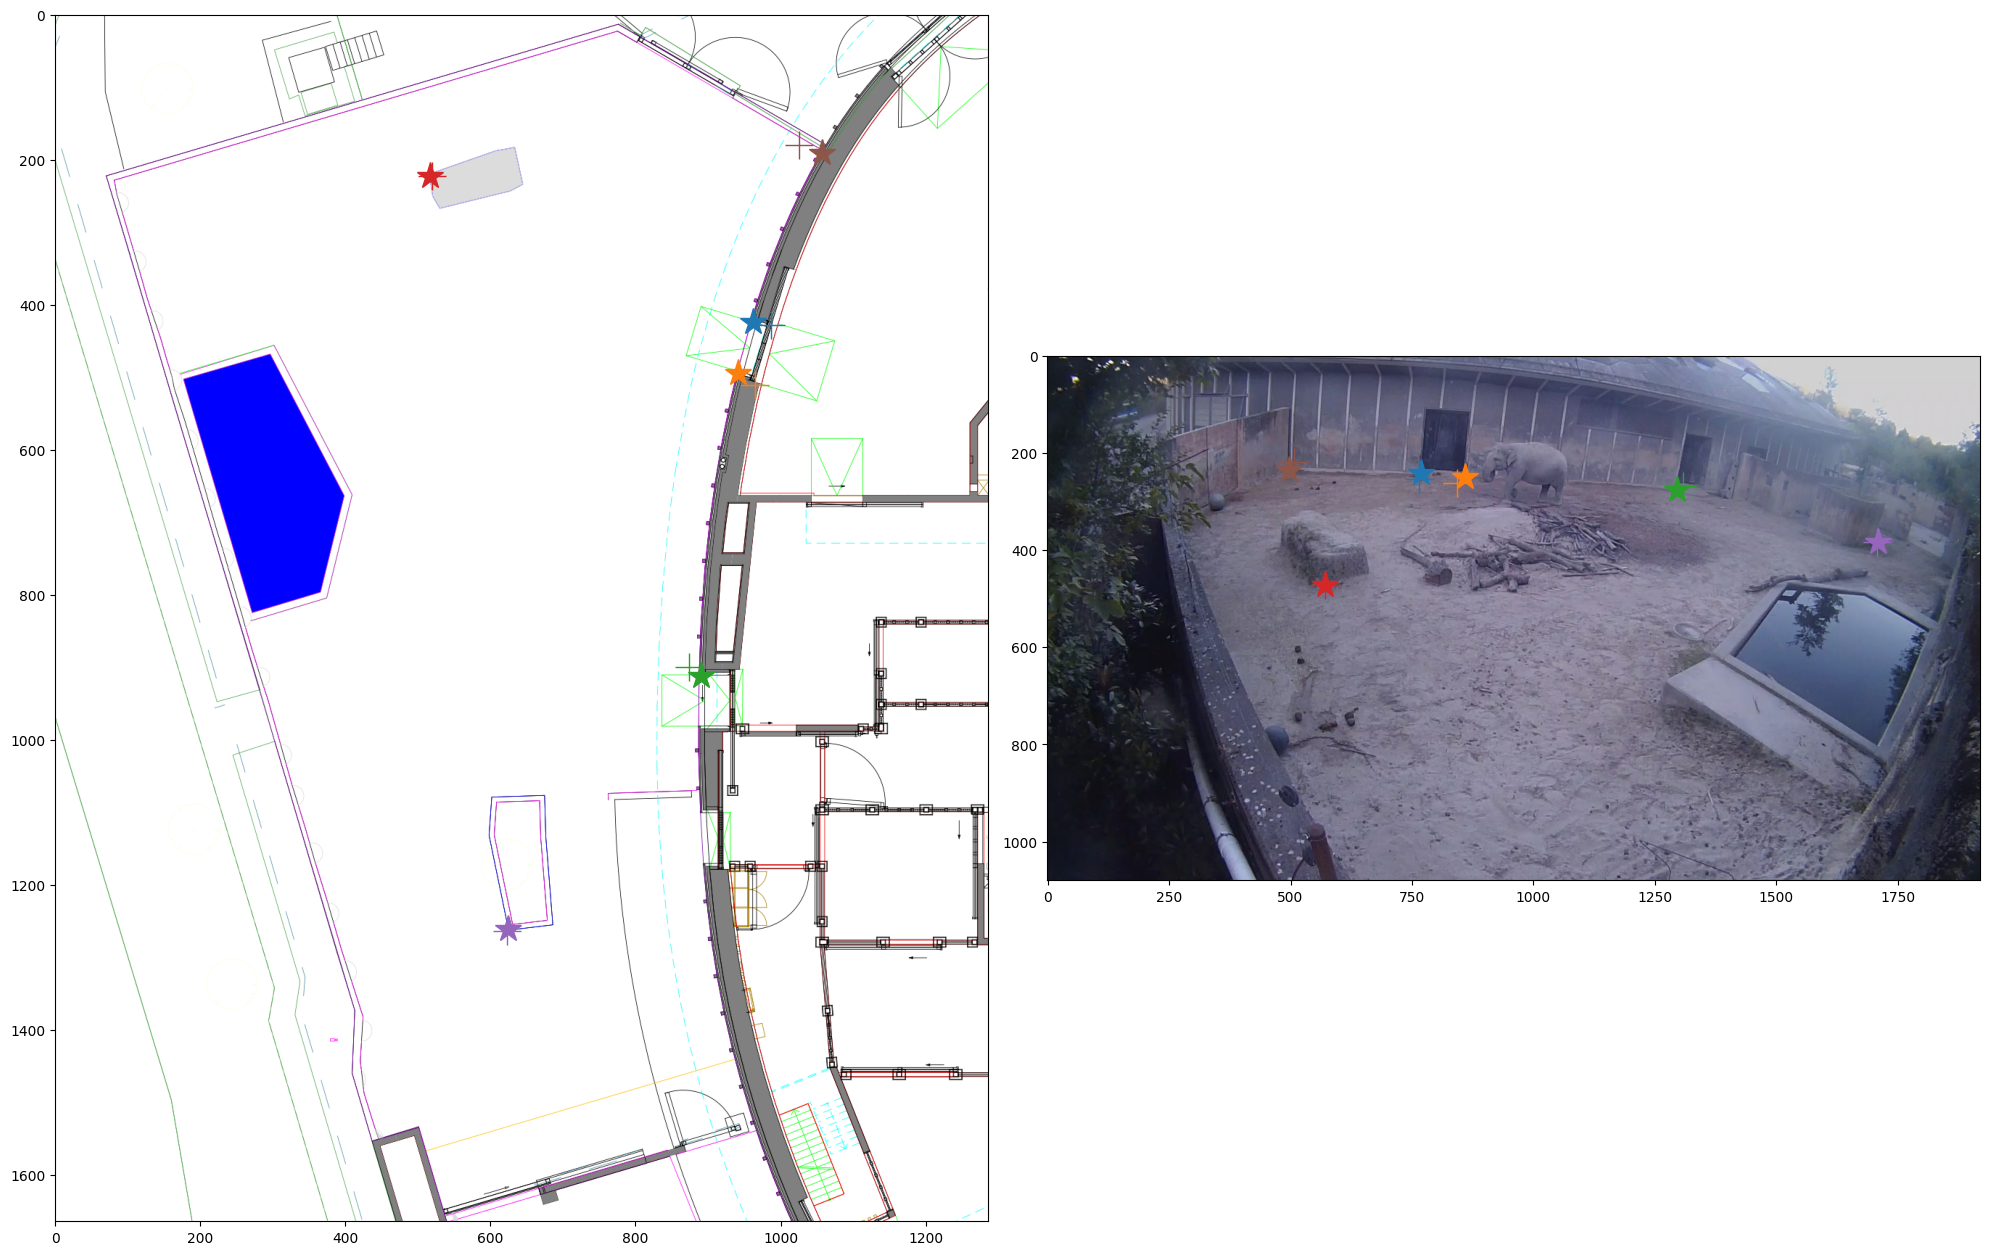

In [8]:
fig,axs = plt.subplots(1,2,figsize=(20,15))
axs[0].imshow(im_submap)
axs[1].imshow(im_camera)
for i in range(camera_points.shape[0]):
    cp = camera_points[[i]]
    wp = submap_points[[i]]
    cp2 =from_h( H_camera_from_submap @ to_h(wp))
    wp2 =from_h( H_submap_from_camera @ to_h(cp))
    c = f"C{i}"
    axs[0].plot(wp[0,0],wp[0,1],"*",markersize=20, color=c)
    axs[0].plot(wp2[0,0],wp2[0,1],"+",markersize=20, color=c)
    axs[1].plot(cp[0,0],cp[0,1],"*",markersize=20, color=c)
    axs[1].plot(cp2[0,0],cp2[0,1],"+",markersize=20, color=c)
fig.tight_layout()
1061, 600

In [9]:
# Decompose homography into K*[R|t]
# Construct a default K matrix
fov = 170 * np.pi / 180 # Assume our cameras have a wide fov
height, width,_ = im_camera.shape
fx = width / np.tan(fov/2)
print(f"H=\n{H_camera_from_world}")

K0 = np.array([[fx,0,width/2],[0,fx,height/2],[0,0,1]])
invK0 = np.linalg.inv(K0)
print(f"{K0=}")

Rt = invK0 @ H_camera_from_world
print(f"Rt=\n{Rt}")

factor = np.linalg.norm(Rt[:,0])
Rt /= factor
r1 = Rt[:,0]
r2 = Rt[:,1]
r3 = np.cross(r1,r2)
R = np.stack([r1,r2,r3])

t = Rt[:,2]
print("First R approximation")
print(R)
print(f"Det={np.linalg.det(R)}")

W,U,Vt=cv2.SVDecomp(R)
R = U@Vt
print("Second R approximation")
print(R)
print(f"Det={np.linalg.det(R)}")

T_camera_from_world = np.concatenate([R,t[:,None]],axis=1)
T_camera_from_world = np.concatenate([T_camera_from_world, [[0,0,0,1]]],axis=0)
T_world_from_camera = np.linalg.inv(T_camera_from_world)
print(f"T_camera_from_world=\n{T_camera_from_world}")
print(f"T_world_from_camera=\n{T_world_from_camera}")



H=
[[-3.02334970e+00 -3.80004697e+01  2.39772951e+03]
 [-1.76877840e+01  1.84433028e+00 -1.17765471e+03]
 [-1.77360146e-03  1.22719661e-03  8.11214983e-01]]
K0=array([[167.97823397,   0.        , 960.        ],
       [  0.        , 167.97823397, 540.        ],
       [  0.        ,   0.        ,   1.        ]])
Rt=
[[-7.86228234e-03 -2.33236042e-01  9.63793394e+00]
 [-9.95964702e-02  7.03450729e-03 -9.61857236e+00]
 [-1.77360146e-03  1.22719661e-03  8.11214983e-01]]
First R approximation
[[-0.07868415 -0.99674157 -0.01774985]
 [-2.33417969  0.07039994  0.01228154]
 [-0.01099193  0.0423977  -2.33211327]]
Det=5.44067070309042
Second R approximation
[[-0.04477349 -0.99883593 -0.01794776]
 [-0.99898605  0.04468102  0.00552081]
 [-0.00471246  0.01817674 -0.99982368]]
Det=0.9999999999999998
T_camera_from_world=
[[-4.47734884e-02 -9.98835929e-01 -1.79477551e-02  9.64545163e+01]
 [-9.98986050e-01  4.46810160e-02  5.52081180e-03 -9.62607495e+01]
 [-4.71246125e-03  1.81767430e-02 -9.99823684e-0

In [25]:
import scipy.optimize
from optimization_helpers import optimizeModel,IModelEvaluator
from dataclasses import dataclass
import scipy

@dataclass
class sKRt:
    scale: float
    K: np.ndarray
    R: np.ndarray
    t: np.ndarray

    def make_homography(self):
        Rt = np.concatenate([self.R,self.t.reshape((3,1))],axis=1)
        Rt = Rt[:,[0,1,3]]
        Hp = self.scale*(self.K @ Rt)
        return Hp

class HomographyEvaluator(IModelEvaluator[sKRt]):
    def __init__(self, homography: np.ndarray, K: np.ndarray):
        super().__init__()
        assert homography.shape == (3,3)
        self.homography = homography
        self.K=K

    def model2params(self, model: sKRt) -> np.ndarray:
        rp,_ = cv2.Rodrigues(model.R)
        rp=rp.reshape((-1))
        tx,ty,tz = model.t.reshape((3))
        # params= np.array([model.K[0,0],model.K[1,1],rp[0],rp[1],rp[2],model.t[0],model.t[1],model.t[2]])
        params_list = [rp[0],rp[1],rp[2],tx,ty,tz]
        return np.array(params_list)

    def params2model(self, params: np.ndarray) -> sKRt:
        rx, ry, rz, tx, ty, tz = params
        R,_=cv2.Rodrigues(np.array([rx,ry,rz]))
        model = sKRt(scale=1,
                    K=self.K,
                    R=R,
                    t=np.array([tx,ty,tz]).reshape((3,1)))
        return model

    def getParamBounds(self) -> scipy.optimize.Bounds|None:
        return None

    def evaluateModel(self, model: sKRt) -> float:
        Hp = model.make_homography()

        sHp = np.linalg.norm(Hp.reshape((-1)))
        sH = np.linalg.norm(self.homography.reshape((-1)))
        Hp = Hp *sH/sHp
        cost = np.linalg.norm((self.homography - Hp).reshape(-1))
        return cost

evaluator = HomographyEvaluator(homography=H_camera_from_world,K=K0)
h_model0 = sKRt(scale=1,K=K0,R=R,t=t)
display(evaluator.evaluateModel(h_model0))
h_model= optimizeModel(evaluator,h_model0,debug=True)


display("")
print(f"Final error: {evaluator.evaluateModel(h_model)}")
print(f"{h_model=}")
Hp = h_model.make_homography()
print(f"{H_camera_from_world=}")
print(f"{Hp=}")

print(f"{h_model=}")


np.float64(146.07294354396984)

         Current function value: 0.020418
         Iterations: 60
         Function evaluations: 880
         Gradient evaluations: 124
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 0.02041827280956324
        x: [ 1.664e+00 -2.671e+00  1.974e-01  6.539e+01 -6.524e+01
             5.501e+00]
      nit: 60
      jac: [-9.316e-02  9.486e-02  8.527e-01  4.703e-02  1.026e-01
             6.024e-01]
 hess_inv: [[ 7.539e-05  4.036e-05 ... -2.691e-03  7.708e-04]
            [ 4.036e-05  2.364e-05 ... -1.018e-03  3.675e-04]
            ...
            [-2.691e-03 -1.018e-03 ...  1.184e+01 -3.631e+00]
            [ 7.708e-04  3.675e-04 ... -3.631e+00  1.122e+00]]
     nfev: 880
     njev: 124


/home/dherrera/git/zoo_vision/env/lib/python3.11/site-packages/scipy/optimize/_minimize.py:733: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


''

Final error: 0.02041827280956324
h_model=sKRt(scale=1, K=array([[167.97823397,   0.        , 960.        ],
       [  0.        , 167.97823397, 540.        ],
       [  0.        ,   0.        ,   1.        ]]), R=array([[-0.44296886, -0.89331274,  0.07596674],
       [-0.89477717,  0.4352029 , -0.09986116],
       [ 0.0561463 , -0.11220869, -0.99209717]]), t=array([[ 65.38943533],
       [-65.24156313],
       [  5.50102012]]))
H_camera_from_world=array([[-3.02334970e+00, -3.80004697e+01,  2.39772951e+03],
       [-1.76877840e+01,  1.84433028e+00, -1.17765471e+03],
       [-1.77360146e-03,  1.22719661e-03,  8.11214983e-01]])
Hp=array([[-2.05086782e+01, -2.57777434e+02,  1.62649812e+04],
       [-1.19984086e+02,  1.25119245e+01, -7.98861169e+03],
       [ 5.61463005e-02, -1.12208686e-01,  5.50102012e+00]])
h_model=sKRt(scale=1, K=array([[167.97823397,   0.        , 960.        ],
       [  0.        , 167.97823397, 540.        ],
       [  0.        ,   0.        ,   1.        ]]), R=a

In [19]:
    
def undistort_points(r_distortion:float,center:np.ndarray,points:np.ndarray)->np.ndarray:
    point_count = points.shape[1]
    np.testing.assert_equal(points.shape,(2,point_count))

    center = center.reshape((2,1))

    points_c = points-center
    points_dist = points_c / r_distortion + center
    
    return points_dist

    
def distort_points(r_distortion:float,center:np.ndarray,points:np.ndarray)->np.ndarray:
    point_count = points.shape[1]
    np.testing.assert_equal(points.shape,(2,point_count))

    center = center.reshape((2,1))

    points_c = points-center
    points_dist = (points_c * r_distortion) + center
    
    return points_dist

center=np.array([5,5])
test_points = np.array([(10,10),(0,0),(10,0)]).T
test_points_d = distort_points(1.5,center,test_points)
display(test_points_d)
display(undistort_points(1.5,center,test_points_d))

array([[12.5, -2.5, 12.5],
       [12.5, -2.5, -2.5]])

array([[10.,  0., 10.],
       [10.,  0.,  0.]])

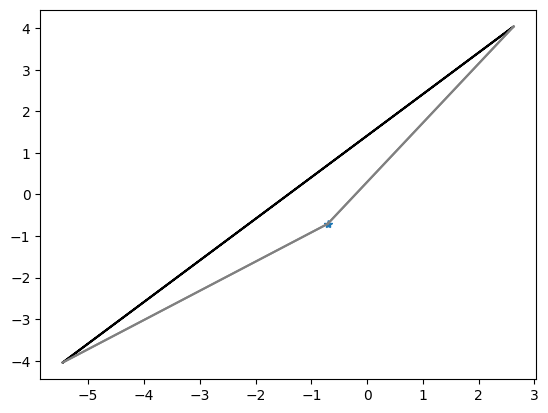

In [139]:
import scipy.spatial


@dataclass
class KRt:
    width: int
    height: int
    r_distortion: float
    K: np.ndarray
    R_camera_from_world: np.ndarray
    t_in_camera: np.ndarray

    def __repr__(self):
        return f"r_dist={self.r_distortion}\nK=\n{self.K}\nR_camera_from_world=\n{self.R_camera_from_world}\nt_in_camera={self.t_in_camera.T}"

    def get_center_in_world(self) -> np.ndarray:
        R_world_from_camera = self.R_camera_from_world.T
        t_in_world = -R_world_from_camera @ self.t_in_camera
        center = t_in_world.reshape((3, 1))
        return center

    def project_points(self, world_points: np.ndarray) -> np.ndarray:
        camera_points_norm = self.K @ (self.R_camera_from_world @ world_points + self.t_in_camera)
        camera_points_undist = camera_points_norm[0:2, :] / camera_points_norm[2, :]
        camera_points = distort_points(
            self.r_distortion, self.K[0:2, 2], camera_points_undist
        )
        return camera_points

    def unproject_points(self, camera_points: np.ndarray, depth=1) -> np.ndarray:
        R_world_from_camera = self.R_camera_from_world.T
        t_world_from_camera = -R_world_from_camera @ self.t_in_camera
        invK = np.linalg.inv(self.K)

        camera_points_undist = undistort_points(
            self.r_distortion, self.K[0:2, 2], camera_points
        )
        camera_points_norm = invK @ (to_h(camera_points_undist.T))

        world_points = (
            R_world_from_camera @ camera_points_norm
        ) * depth + t_world_from_camera
        return world_points


def plot_camera(ax, model: KRt, scale=1, T_image_from_world: np.ndarray | None=None):
    center = model.get_center_in_world().squeeze()
    h, w = model.height, model.width
    p = np.array([[0, 0], [0, h], [w, h], [w, 0]]).T
    xy = model.unproject_points(p, scale)

    # Drop z
    xy = xy[0:2,:]

    if T_image_from_world is not None:
        xyh = np.concatenate([xy,np.ones((1,xy.shape[1]))],axis=0)
        print(xyh.shape)
        xyh = T_image_from_world @ xyh
        xy = xyh[0:3,:]

    # ax.plot([center[0,0],x[0,0],x[0,1],center[0,0]],[center[1,0],x[1,0],x[1,1],center[1,0]],"-", color="black")
    # print(x)
    x = xy[0, :]
    y = xy[1, :]
    ax.plot([center[0]], [center[1]], "*")
    ax.plot(
        [x[0], x[1], x[2], x[3], x[0]],
        [y[0], y[1], y[2], y[3], y[0]],
        "-",
        color="black",
    )
    for i in range(4):
        ax.plot([center[0], x[i]], [center[1], y[i]], "-", color="gray")


R = scipy.spatial.transform.Rotation.from_euler(
    seq="xyz", angles=[np.pi / 2, np.pi / 4, 0]
).as_matrix()
# print(R)
dummy_model = KRt(
    width=width,
    height=height,
    r_distortion=1,
    K=K0,
    R_camera_from_world=R,
    t_in_camera=np.array([1, 0, 0]).reshape((3, 1)),
)
_, ax = plt.subplots(1, 1)
plot_camera(ax, dummy_model, scale=1)

Final errors: [[-2.56446031e+01 -2.47114968e+01 -1.27597490e+01 -5.96476073e+01
  -6.52131317e+01 -2.50167254e+01]
 [ 1.36383837e+00  8.20470501e-02 -4.73084968e+00  9.25343216e+00
  -3.02068993e+01  6.30105789e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 5.23497072e+00  1.13029197e+01 -6.43535735e+01 -3.38144115e+01
   4.58248780e+01  3.25881446e+01]
 [-6.58141457e+01 -5.64401459e+01 -1.26092961e+01  1.50213964e+02
   9.93376524e+01 -8.15077959e+01]]
model=r_dist=1
K=
[[165.19057257   0.         960.        ]
 [  0.          20.30033213 540.        ]
 [  0.           0.           1.        ]]
R_camera_from_world=
[[-0.06724649  0.9974499   0.02390845]
 [-0.99280483 -0.06927445  0.09767095]
 [ 0.09907812 -0.01716839  0.99493154]]
t_in_camera=[[-49.35932817 -28.69982685   4.57664671]]
camera_center_in_world=array([[-32.26601374],
       [ 47.3238656 ],
       [ -0.57020596]])
(3, 4)


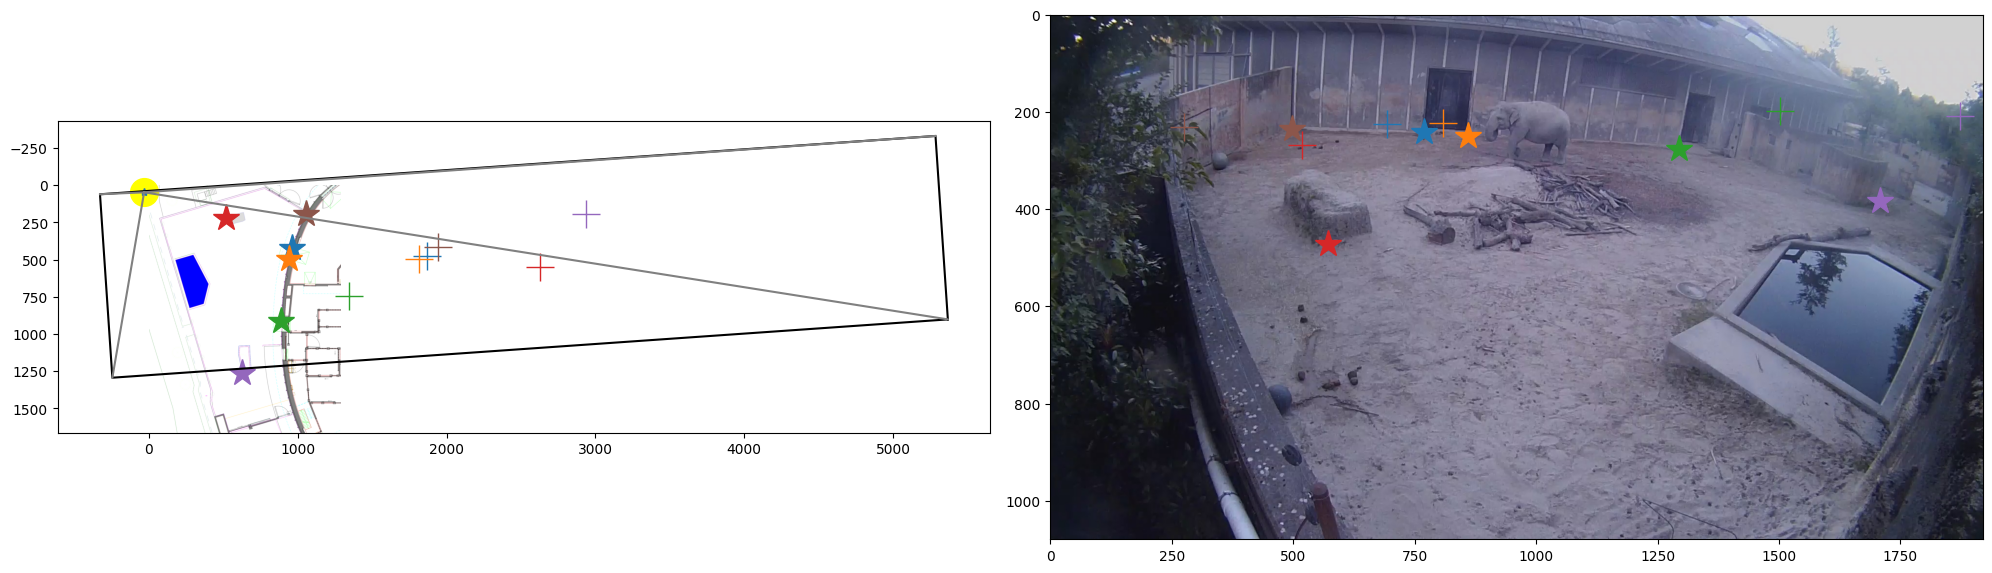

In [148]:
class ProjectionEvaluator(IModelEvaluator[KRt]):
    def __init__(
        self, camera_points: np.ndarray, world_points: np.ndarray, model0: KRt
    ):
        super().__init__()
        point_count = world_points.shape[0]
        self.world_points = world_points.T
        if self.world_points.shape[0] == 2:
            self.world_points = np.concatenate([self.world_points, np.zeros((1,point_count))],axis=0)

        self.camera_points = camera_points.T
        self.model0 = model0

    def model2params(self, model: KRt) -> np.ndarray:
        rp, _ = cv2.Rodrigues(model.R_camera_from_world)
        rx, ry, rz = rp.reshape((3,))
        tx, ty, tz = model.t_in_camera.reshape((3,))

        fx = model.K[0, 0]
        alpha = model.K[1, 1] / model.K[0, 0]

        params_list = [model.r_distortion, fx, alpha, rx, ry, rz, tx, ty, tz]
        return np.array(params_list)

    def params2model(self, params: np.ndarray) -> KRt:
        r_distortion, fx, alpha, rx, ry, rz, tx, ty, tz = params

        # alpha=1
        r_distortion=1
        R, _ = cv2.Rodrigues(np.array([rx, ry, rz]))
        t = np.array([tx, ty, tz]).reshape((3, 1))
        # t[2, 0] = 3

        K = self.model0.K.copy()
        K[0, 0] = fx
        K[1, 1] = fx * alpha

        model = KRt(
            width=self.model0.width,
            height=self.model0.height,
            r_distortion=r_distortion,
            K=K,
            R_camera_from_world=R,
            t_in_camera=t,
        )
        return model

    def getParamBounds(self) -> scipy.optimize.Bounds:
        lb = np.full((9,), -np.inf)
        lb[0] = 0.1
        lb[1] = 0.1
        lb[2] = 0.1
        return scipy.optimize.Bounds(lb=lb)

    def compute_world_points(self, model: KRt,debug=False) -> np.ndarray:
        center = model.get_center_in_world()

        world_points_d1 = model.unproject_points(self.camera_points)
        x_dir = world_points_d1 - center

        depth = -center[2,0] / x_dir[2,:]
        world_points_exp = center + x_dir*depth

        if debug:
            print(f"{self.camera_points=}\n{world_points_d1=}\n{x_dir=}\n{depth=}\n{world_points_exp=}")
        return world_points_exp

    def compute_errors(self, model: KRt,debug=False) -> np.ndarray:
        world_points_exp = self.compute_world_points(model,debug)
        errors_world = self.world_points - world_points_exp

        camera_points_exp = model.project_points(self.world_points)
        errors_camera = self.camera_points - camera_points_exp
        
        t_in_world = model.get_center_in_world()
        return np.concatenate([errors_world,errors_camera],axis=0)

    def evaluateModel(self, model: KRt) -> float:
        return np.linalg.norm(self.compute_errors(model))


model0 = KRt(width=width, height=height, r_distortion=1, K=h_model.K, R_camera_from_world=h_model.R, t_in_camera=h_model.t)
evaluator = ProjectionEvaluator(
    camera_points=camera_points, world_points=world_points, model0=model0
)
# display(m0)
errors0 = evaluator.compute_errors(model0)
# display(errors0)
model = optimizeModel(evaluator, model0, debug=False)
# model=model0
# display("")
print(f"Final errors: {evaluator.compute_errors(model,debug=False)}")
print(f"{model=}")

camera_center_in_world = model.get_center_in_world()
print(f"{camera_center_in_world=}")

# Display points
world_points_exp = evaluator.compute_world_points(model)[0:2,:].T
submap_points_exp = from_h(T_submap_from_world @ to_h(world_points_exp))
camera_points_exp = model.project_points(to_h(world_points))

fig, axs = plt.subplots(1, 2, figsize=(20, 15))
axs[0].imshow(im_submap)
axs[1].imshow(im_camera)
for i in range(camera_points.shape[0]):
    cp = camera_points[[i]]
    wp = submap_points[[i]]
    cp2 = camera_points_exp[:, [i]].T
    wp2 = submap_points_exp[[i]]
    c = f"C{i}"
    axs[0].plot(wp[0, 0], wp[0, 1], "*", markersize=20, color=c)
    axs[0].plot(wp2[0, 0], wp2[0, 1], "+", markersize=20, color=c)
    axs[1].plot(cp[0, 0], cp[0, 1], "*", markersize=20, color=c)
    axs[1].plot(cp2[0, 0], cp2[0, 1], "+", markersize=20, color=c)
axs[0].plot(
    camera_center_in_world[0, 0],
    camera_center_in_world[1, 0],
    "o",
    markersize=20,
    color="yellow",
)
plot_camera(axs[0], model,scale=3, T_image_from_world=T_submap_from_world)
fig.tight_layout()

In [ ]:
x=evaluator.world_points[:,[0]]
print(model.project_points(x))

points_in_camera = model.R_camera_from_world @ x + model.t_in_camera
points_in_image_undist = model.K@points_in_camera
points_in_image_undist = points_in_image_undist[0:2,:] / points_in_image_undist[2,:]
points_in_image = distort_points(model.r_distortion, model.K[0:2,2], points_in_image_undist)

points_in_image

[[766.87514076]
 [254.74339792]]


array([[766.87514076],
       [254.74339792]])

array([-91.80628268, 100.49569703,   1.        ])

uv=array([[960.],
       [540.],
       [  1.]])
uvnorm=array([[0.],
       [0.],
       [1.]])
x=array([[-8.23813602e+01],
       [ 6.41422111e+01],
       [ 2.01002699e+03],
       [ 1.00000000e+00]])
s=array([[ 733.80465003],
       [-117.09674865],
       [   1.        ]])


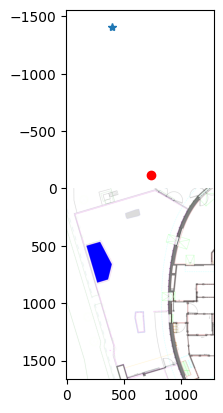

In [182]:
from tqdm import tqdm

camera_in_world = T_world_from_camera[0:3,3].copy()
camera_in_world[2]  = 1
camera_in_submap = T_submap_from_world@camera_in_world
display(camera_in_world)

xs=[]
for u in [width/2]:
# for u in range(0,width,50):
    uv = np.array([[u,height/2,1]]).T
    print(f"{uv=}")
    uvnorm = invK@uv
    print(f"{uvnorm=}")
    uvnorm[2] = -2000
    x  = T_world_from_camera @ np.concatenate([uvnorm,[[1]]],axis=0)
    print(f"{x=}")
    x[2] =1
    s = T_submap_from_world@x[:3]
    print(f"{s=}")
    xs.append(s)
xs = np.asarray(xs)
# print(len(xs[0]))

plt.imshow(im_submap)
plt.plot(xs[:,0],xs[:,1],"o-",color="red")
plt.plot(camera_in_submap[0],camera_in_submap[1],"*")


In [32]:
import json
from pathlib import Path

config_file = Path("../data/config.json")
try:
    with config_file.open() as f:
        config = json.load(f)
except:
    config = {}

if "cameras" not in config:
    config["cameras"] = {}
if camera_name not in config["cameras"]:
    config["cameras"][camera_name] = {}
    camera_config = config["cameras"][camera_name]


camera_config["H_worldFromCamera"] = H_world_from_camera.tolist()
config_json = json.dumps(config,indent=2)
print(config_json)

with config_file.open("w") as f:
    f.write(config_json)

{
  "map": {
    "image": "kkep_floorplan.png",
    "T_world_from_image": [
      [
        0.0282213293,
        0.0,
        -120.756855
      ],
      [
        -0.0,
        -0.028214592,
        103.160262
      ],
      [
        0.0,
        0.0,
        1.0
      ]
    ]
  },
  "cameras": {
    "Kamera 01": {
      "H_worldFromCamera": [
        [
          -0.004340083756349658,
          -0.0498274040212114,
          -59.50719726737088
        ],
        [
          -0.02425379470263873,
          -0.002656007731721079,
          67.83180827340627
        ],
        [
          2.7201908673595802e-05,
          -0.00010492226397889542,
          1.0
        ]
      ]
    }
  }
}


In [78]:
# 468, 437
p = np.array([[680,258,1]]).reshape((3,1))
from_h(H@p)

array([[468.06075567, 437.65881785]])